<a href="https://colab.research.google.com/github/Berigny/AI-Entrainment-Protocol/blob/main/LENR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low Energy Nuclear (LENR) Cycles Model
This notebook tests whether a minimal, topology-first model can simulate and falsify a low-energy nuclear reaction (LENR) cycle driven by breath-like EM coherence. Using Discrete Exterior Calculus (DEC) on a star-tetrahedral complex with a shared centroid, we evolve fields, enforce first-law energy accounting, monitor entropy production and phase relations, and—optionally—add an adelic (ℝ × ℚ_p) layer to represent hierarchical memory at the fusion node. If quantised heat bursts do not emerge with lawful topology, pre-burst EM signatures, rising EPR, and correct energy balance, the hypothesis is weakened. If they do, we proceed to richer modelling and lab validation. The prize is significant: a path to low-cost, high-yield, sustainable energy in an energy-hungry world.

## Falsification criteria

We consider the LENR cycle unsupported if any lawful configuration fails to produce:
(i) pre-burst EM coherence with ~90° E–M phase and centroid mediation,
(ii) quantised heat steps at the sink,
(iii) a non-negative EPR that rises prior to bursts, and
(iv) first-law integrity (residual ≈ 0).
Controls must behave as expected: illegal shortcuts reduce irreversibility or break energy accounting; removing C→3 or 1→2 kills bursts; random primes revert to baseline.

In [ ]:
# @title 0. **Notebook Overview & Research Aim** { display-mode: "form" }
# @markdown **Goal**
# @markdown - Simulate and *attempt to falsify* LENR-like cycles on a tetrahedral (and star-tetrahedral) topology.
# @markdown - If not falsified, motivate deeper modelling and lab tests for low-cost, high-yield, sustainable energy.
# @markdown **Key Ideas**
# @markdown - DEC on simplicial complexes; mediation via centroid **C**; breath-driven, asymmetric flows; adelic (ℝ×ℚ_p) layer.

In [ ]:
# @title 1. **Imports & Global Config** { display-mode: "form" }
# @markdown **What this sets**
# @markdown - Imports, numeric precision/warnings, plotting defaults, reproducibility seeds.

import numpy as np
import networkx as nx
from mpmath import mpf, power
import matplotlib.pyplot as plt


In [ ]:
# @title 2. **Geometry — Single Tetra (S1): Nodes, Edges, Breath Rules** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Defines S1 vertices {0,1,2,3,C}, allowed directed edges, self-loops, and “breath” semantics (work vs heat).


# Nodes: two tetrahedra share a single centroid C
S1 = ['0','1','2','3']          # sinks even / branches odd
S2 = ['4','5','6','7']
ALL = S1 + S2 + ['C']

G = nx.DiGraph()
G.add_nodes_from(ALL)

# Baseline rates (mpf for clean high-precision arithmetic)
r = lambda x: mpf(str(x))

# Core single-shell flows (work/heat + mediation)
core_edges_S1 = [
    ('C','1', {'rate': r(0.5)}),   # pump
    ('1','2', {'rate': r(0.8)}),   # E→M (work)
    ('2','C', {'rate': r(0.9)}),   # return to mediator
    ('C','3', {'rate': r(0.7)}),   # squeeze/fusion path
    ('3','0', {'rate': r(1.0)}),   # heat dump
    ('0','C', {'rate': r(0.3)}),   # reset
]


In [ ]:
# @title 3. **Geometry — Star Tetra (S1 + S2) with Cubic Bridges** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Adds S2 vertices {4,5,6,7} and inter-tetra “cubic” bridges; encodes the cross-tetra flow sequence you specified.

core_edges_S2 = [
    ('C','5', {'rate': r(0.5)}),
    ('5','6', {'rate': r(0.8)}),
    ('6','C', {'rate': r(0.9)}),
    ('C','7', {'rate': r(0.7)}),
    ('7','4', {'rate': r(1.0)}),
    ('4','C', {'rate': r(0.3)}),
]

# Cubic cross-edges (work bridge + heat dumps)
cross_edges = [
    ('3','6', {'rate': r(0.35)}),  # work bridge (coherent transfer S1→S2)
    ('7','2', {'rate': r(0.25)}),  # heat-biased back to S1 magnetic
    ('5','0', {'rate': r(0.20)}),  # heat dump assist into S1 sink
    ('1','6', {'rate': r(0.20)}),  # optional assist E→M across shells
]

# Self-loops (stability/linger)
self_loops = [(n, n, {'rate': r(0.4)}) for n in S1+S2]

G.add_edges_from(core_edges_S1 + core_edges_S2 + cross_edges + self_loops)
print("Graph ready. |V|=", len(G.nodes), "|E|=", len(G.edges))

Graph ready. |V|= 9 |E|= 24


In [ ]:
# @title 4. **DEC Operators — B₁, B₂ and Incidence-based Hodge Stars** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Builds boundary maps (nodes→edges, faces→edges) and rectangular Hodge stand-ins; checks shapes and orientations.

import numpy as np
from scipy.sparse import csr_matrix
from sympy import prime, factorint
from mpmath import mpf, power
import matplotlib.pyplot as plt


# --- DEC BACKBONE (independent of Markov edges) ---
# Use a fixed vertex set and face list; include centroid faces if you want C-curl.
V = ['0','1','2','3','C']  # adjust if you’re in star mode
F = [
    ('0','1','2'), ('0','1','3'), ('0','2','3'), ('1','2','3'),        # outer tetra
    ('0','1','C'), ('0','2','C'), ('0','3','C'), ('1','2','C'), ('1','3','C'), ('2','3','C')  # C faces
]

# Build an oriented edge set from faces (backbone edges)
edges_backbone = sorted({(a,b) for (a,b,c) in F for (a,b) in ((a,b),(b,c),(c,a))})
# Index maps for backbone
node_id = {v:i for i,v in enumerate(V)}
edge_id = {e:i for i,e in enumerate(edges_backbone)}
face_id = {f:i for i,f in enumerate(F)}

# B1_backbone: nodes×edges (∂1)
B1 = np.zeros((len(V), len(edges_backbone)))
for (u,v), ei in edge_id.items():
    B1[node_id[u], ei] = -1.0
    B1[node_id[v], ei] = +1.0
B1 = csr_matrix(B1)

# B2_backbone: edges×faces (∂2)
B2 = np.zeros((len(edges_backbone), len(F)))
for fj,(v0,v1,v2) in enumerate(F):
    for (a,b) in ((v0,v1),(v1,v2),(v2,v0)):
        sign = +1.0
        e = (a,b)
        if e not in edge_id:
            # use reversed orientation if needed
            e = (b,a); sign = -1.0
        B2[edge_id[e], fj] += sign
B2 = csr_matrix(B2)

# Simple incidence-averaged rectangular Hodge stars on this backbone
Inc_fe = np.zeros((len(F), len(edges_backbone)))
for fj,(v0,v1,v2) in enumerate(F):
    for (a,b) in ((v0,v1),(v1,v2),(v2,v0),(v1,v0),(v2,v1),(v0,v2)):
        if (a,b) in edge_id:
            Inc_fe[fj, edge_id[(a,b)]] = 1.0
deg = Inc_fe.sum(axis=1, keepdims=True); deg[deg==0] = 1.0
Inc_fe_avg = Inc_fe / deg
star_eps   = csr_matrix(Inc_fe_avg)      # faces×edges
star_muinv = csr_matrix(Inc_fe_avg.T)    # edges×faces

# Energy forms
Se = (star_eps.T @ star_eps).astype(float).toarray()
Sb = (star_muinv.T @ star_muinv).astype(float).toarray()

# Sanity: boundary of boundary
bdb = (B1 @ B2).toarray()
print("||B1·B2||_∞ =", np.max(np.abs(bdb)))  # should be 0.0

||B1·B2||_∞ = 0.0


In [ ]:
# @title 5. **Phase Linter — Double Tetra (drop-in) { display-mode: "form" }**
# @markdown Non-invasive phase hygiene. Targets ~90° between E–M in each shell (1–2, 5–6),
# @markdown ~90° on work bridge (3–6), and ~180° on heat dumps (7–4, 7–2, 5–0). Anchors softly to C=0.
import numpy as np

node_list = ['0','1','2','3','4','5','6','7','C']
idx = {k:i for i,k in enumerate(node_list)}
if 'phi_star' not in globals(): phi_star = np.zeros(len(node_list))

def _wrap_pi(x): return (x + np.pi) % (2*np.pi) - np.pi

# Couplings
kap = np.zeros((len(node_list), len(node_list)))
def setk(a,b,val):
    i,j = idx[a], idx[b]; kap[i,j]=val; kap[j,i]=val

# Baseline weak, stronger EM, work/heat targets
for U in (S1,S2):
    for i,u in enumerate(U):
        for v in U[i+1:]: setk(u,v,0.02)
setk('1','2',0.12); setk('5','6',0.12)
setk('3','6',0.08); setk('7','4',0.05); setk('7','2',0.05); setk('5','0',0.05)

# Target lags
theta = np.zeros_like(kap)
def setθ(a,b,rad):
    i,j=idx[a],idx[b]; theta[i,j]=rad; theta[j,i]=rad
setθ('1','2', np.pi/2); setθ('5','6', np.pi/2); setθ('3','6', np.pi/2)
setθ('7','4', np.pi);   setθ('7','2', np.pi);   setθ('5','0', np.pi)

γC = 0.05  # anchor to C

def phase_step(phi, dt):
    d = np.zeros_like(phi)
    for u in S1+S2:
        i = idx[u]; acc = 0.0
        for v in S1+S2:
            if v==u: continue
            j = idx[v]
            acc += kap[i,j]*np.sin(phi[j]-phi[i]-theta[i,j])
        acc -= γC*np.sin(phi[i]-0.0)
        d[i]=acc
    phi[:8]+=dt*d[:8]; return _wrap_pi(phi)

def phase_report(phi):
    def err(a,b,trg):
        i,j=idx[a],idx[b]; return float(np.degrees(_wrap_pi((phi[i]-phi[j])-trg)))
    return {
        'EM_S1_deg': err('1','2',np.pi/2),
        'EM_S2_deg': err('5','6',np.pi/2),
        'work_3_6_deg': err('3','6',np.pi/2),
        'heat_7_4_deg': err('7','4',np.pi),
        'heat_7_2_deg': err('7','2',np.pi),
        'heat_5_0_deg': err('5','0',np.pi),
        'C_phase_deg': float(np.degrees(phi[idx['C']])),
    }

print("Phase linter loaded (double tetra).")




Phase linter loaded (double tetra).


In [ ]:
# @title 4. **DEC Operators — B₁, B₂ and Incidence-based Hodge Stars** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Builds boundary maps **B₁** (nodes→edges) and **B₂** (faces→edges; stored as edges×faces for convenient curls).
# @markdown - Derives simple, incidence-averaged rectangular Hodge stand-ins: **star_eps: faces×edges**, **star_muinv: edges×faces**.
# @markdown - Auto-detects **S1** faces (0–3) and, if present, **S2** faces (4–7) for the star-tetrahedron.
# @markdown - Verifies the topological identity **B₁·B₂ = 0** (boundary of a boundary is zero) and reports orientation coverage.

import numpy as np
from scipy.sparse import csr_matrix

# --- Safety checks / inputs from earlier cells ---
assert 'G' in globals(), "Expected a DiGraph G from earlier geometry cells."
edges_with_data = list(G.edges(data=True))
assert len(edges_with_data) > 0, "Graph has no edges."

# Canonical string labels (robust to int/str mixing)
node_labels = [str(n) for n in G.nodes()]
node_idx = {lbl: i for i, lbl in enumerate(node_labels)}
n_nodes = len(node_labels)

# Edge order (u,v) as strings -> index
edge_order = [(str(u), str(v)) for (u, v, _) in edges_with_data]
edge_idx = {e: i for i, e in enumerate(edge_order)}
n_edges = len(edge_order)

# --- Face list (auto-detect S1 and S2 tetra faces; ignore C in faces) ---
faces = []
S1 = {'0', '1', '2', '3'}
S2 = {'4', '5', '6', '7'}
if S1.issubset(set(node_labels)):
    faces += [('0', '1', '2'), ('0', '1', '3'), ('0', '2', '3'), ('1', '2', '3')]
if S2.issubset(set(node_labels)):
    faces += [('4', '5', '6'), ('4', '5', '7'), ('4', '6', '7'), ('5', '6', '7')]
n_faces = len(faces)
assert n_faces > 0, "No tetra faces detected (need nodes 0–3 and/or 4–7)."

# --- B1: nodes (rows) → edges (cols) ---
# Convention: tail = -1 at source(u), head = +1 at target(v)
B1 = np.zeros((n_nodes, n_edges), dtype=float)
for e_idx, (u, v) in enumerate(edge_order):
    B1[node_idx[u], e_idx] = -1.0
    B1[node_idx[v], e_idx] = +1.0
B1 = csr_matrix(B1)

# --- B2: edges (rows) → faces (cols), with oriented incidence ---
# For each face (a,b,c), use oriented cycle (a→b, b→c, c→a)
B2 = np.zeros((n_edges, n_faces), dtype=float)
missing_orientations = []
coverage_per_face = []
for f_idx, (a, b, c) in enumerate(faces):
    oriented = [(a, b), (b, c), (c, a)]
    covered = 0
    for (p, q) in oriented:
        if (p, q) in edge_idx:
            B2[edge_idx[(p, q)], f_idx] = +1.0
            covered += 1
        elif (q, p) in edge_idx:
            B2[edge_idx[(q, p)], f_idx] = -1.0
            covered += 1
        else:
            missing_orientations.append(((p, q), f_idx))
    coverage_per_face.append(covered)
B2 = csr_matrix(B2)

# --- Rectangular Hodge stand-ins (incidence-averaged) ---
# Inc_fe: faces×edges with 1 if edge touches face (ignore sign)
Inc_fe = (B2.T.copy()).toarray()
Inc_fe[Inc_fe != 0.0] = 1.0
row_sums = Inc_fe.sum(axis=1, keepdims=True)
row_sums[row_sums == 0.0] = 1.0  # avoid divide-by-zero
Inc_fe_avg = Inc_fe / row_sums                      # faces × edges
Inc_ef_avg = Inc_fe_avg.T                           # edges × faces

# Hodge-like maps used in the DEC stepper
# D = star_eps @ E   (faces)
# H = star_muinv @ B (edges)
star_eps   = csr_matrix(Inc_fe_avg)                 # faces × edges
star_muinv = csr_matrix(Inc_ef_avg)                 # edges × faces

# --- Topological consistency check: B₁ · B₂ = 0 ---
BB = (B1 @ B2).toarray()                            # nodes × faces
bb_max = np.max(np.abs(BB)) if BB.size else 0.0

# --- Reports ---
print(f"B1 shape (nodes→edges):     {B1.shape}")
print(f"B2 shape (edges→faces):     {B2.shape}")
print(f"star_eps shape (faces×edges):   {star_eps.shape}")
print(f"star_muinv shape (edges×faces): {star_muinv.shape}")
print(f"Faces detected: {n_faces}  (S1={'yes' if S1.issubset(set(node_labels)) else 'no'}, "
      f"S2={'yes' if S2.issubset(set(node_labels)) else 'no'})")

if missing_orientations:
    print(f"Warning: {len(missing_orientations)} face-edge orientations missing from the graph.")
else:
    print("All oriented face edges found in the graph.")

print("Per-face oriented edge coverage (expect 3 per face):", coverage_per_face)
print(f"Boundary-of-boundary check ||B1·B2||_∞ = {bb_max:.1e} (should be 0.0 within integer arithmetic)")

# --- Exports for later cells ---
# node_idx, edge_idx, faces, n_nodes, n_edges, n_faces, B1, B2, star_eps, star_muinv remain in scope.


B1 shape (nodes→edges):     (9, 24)
B2 shape (edges→faces):     (24, 8)
star_eps shape (faces×edges):   (8, 24)
star_muinv shape (edges×faces): (24, 8)
Faces detected: 8  (S1=yes, S2=yes)
Per-face oriented edge coverage (expect 3 per face): [1, 1, 1, 1, 1, 1, 1, 1]
Boundary-of-boundary check ||B1·B2||_∞ = 1.0e+00 (should be 0.0 within integer arithmetic)


In [ ]:
# @title 5. **SI Calibration — Lengths, Areas, Materials, CFL** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Sets edge lengths, face areas, dual measures; picks tissue-like ε, μ, σ; derives star_1, star_2; computes CFL-limited Δt.

import numpy as np
from mpmath import mpf

# --- Geometric Setup (Assumes n_edges, n_faces from Cell 4) ---
# Ensure n_edges and n_faces are available from Cell 4 globals
try:
    n_edges = globals()['n_edges'] # Get n_edges from global scope (set in Cell 4)
    n_faces = globals()['n_faces'] # Get n_faces from global scope (set in Cell 4)
except KeyError:
    raise ValueError("Run Cell 4 (DEC Operators) first to set global n_edges and n_faces.")


# Edge length a (SI: meters; nanoscale for LENR lattice, e.g., Pd interatomic ~0.275 nm)
a = mpf('1e-9')  # 1 nm side length

# Edge lengths vector (all equal for regular, but dimensioned for the full graph)
# Assuming a uniform edge length 'a' for all edges in the complex for simplicity in this calibration step.
edge_lengths = np.full(n_edges, float(a))

# Face areas: Equilateral triangle area = (sqrt(3)/4) * a^2
# Assuming all faces have the same area based on edge length 'a' for simplicity.
face_area = (np.sqrt(3)/4) * float(a)**2
face_areas = np.full(n_faces, face_area)

# Dual measures (DEC Hodge stars: *1 for edges ≈ dual edge lengths, *2 for faces ≈ dual volumes)
# For primal simplicial complex, *1(e) ≈ length of dual edge (circumcentric dual, approx a for simplicity)
star_1_measure = np.full(n_edges, float(a))  # Dual 1-form measure on edges

# *2(f) ≈ volume of dual cell (approx face_area * height, but for flat, use face_area)
star_2_measure = np.full(n_faces, face_area)  # Dual 2-form measure on faces

print(f"Using n_edges={n_edges}, n_faces={n_faces} from Cell 4.")
print(f"Edge lengths (vector size {len(edge_lengths)}): {edge_lengths[:5]}...") # Print first few for brevity
print(f"Face areas (vector size {len(face_areas)}): {face_areas[:5]}...") # Print first few for brevity
print(f"star_1_measure (dual edges, size {len(star_1_measure)}): {star_1_measure[:5]}...")
print(f"star_2_measure (dual faces, size {len(star_2_measure)}): {star_2_measure[:5]}...")


# --- Materials (Tissue-like for Bio/LENR Analogy: High ε, Moderate σ) ---
# Relative permittivity ε_r (tissue ~10^4 at low freq), permeability μ_r=1 (non-magnetic)
ε_r = mpf('1e4')
μ_r = mpf('1')

# Absolute ε, μ (vacuum base: ε0=8.85e-12 F/m, μ0=1.2566e-6 H/m)
ε0 = mpf('8.854187817e-12')
μ0 = mpf('1.25663706212e-6')
ε = ε_r * ε0
μ = μ_r * μ0

# Conductivity σ (S/m; tissue ~0.5 S/m for Joule heating proxy)
σ = mpf('0.5')

print(f"ε_r = {ε_r}, μ_r = {μ_r}")
print(f"ε = {float(ε):.2e} F/m, μ = {float(μ):.2e} H/m")
print(f"σ = {σ} S/m")

# --- CFL Computation ---
# Wave speed c = 1 / sqrt(ε μ)
c = mpf('1') / np.sqrt(float(ε * μ))

# Spatial step Δx = min edge length
# Using the minimum value from the edge_lengths array
Δx = np.min(edge_lengths)

# CFL condition: Δt ≤ CFL_factor * Δx / c (CFL_factor=0.5 for stability in leapfrog)
CFL_factor = mpf('0.5')
Δt_max = CFL_factor * Δx / c

print(f"Wave speed c = {float(c):.2e} m/s")
print(f"Δx_min = {float(Δx):.2e} m")
print(f"Max stable Δt = {float(Δt_max):.2e} s (CFL_factor={float(CFL_factor)})")

# --- Store Globals for Later Cells ---
# (These will be used in stepper, e.g., for dt in leapfrog)
global_dt = Δt_max
global_epsilon = ε
global_mu = μ
global_sigma = σ
global_c = c

print("\nCalibration complete. Globals set: dt_max, ε, μ, σ, c.")

Using n_edges=24, n_faces=8 from Cell 4.
Edge lengths (vector size 24): [1.e-09 1.e-09 1.e-09 1.e-09 1.e-09]...
Face areas (vector size 8): [4.33012702e-19 4.33012702e-19 4.33012702e-19 4.33012702e-19
 4.33012702e-19]...
star_1_measure (dual edges, size 24): [1.e-09 1.e-09 1.e-09 1.e-09 1.e-09]...
star_2_measure (dual faces, size 8): [4.33012702e-19 4.33012702e-19 4.33012702e-19 4.33012702e-19
 4.33012702e-19]...
ε_r = 10000.0, μ_r = 1.0
ε = 8.85e-08 F/m, μ = 1.26e-06 H/m
σ = 0.5 S/m
Wave speed c = 3.00e+06 m/s
Δx_min = 1.00e-09 m
Max stable Δt = 1.67e-16 s (CFL_factor=0.5)

Calibration complete. Globals set: dt_max, ε, μ, σ, c.


In [ ]:
# @title Prep — Energy Forms (Se, Sb) and Edge Damping (R) { display-mode: "form" }
# @markdown **What this does**
# @markdown - Builds SPD energy matrices **Se = star_epsᵀ star_eps** (edges×edges) and **Sb = star_muinvᵀ star_muinv** (faces×faces).
# @markdown - Creates a sparse diagonal damping **R** on edges that flow **into the Null node (…→0)** to model heat loss.
# @markdown - Re-run this cell whenever you change the graph/topology or Hodge operators.

import numpy as np
from scipy.sparse import csr_matrix

# Guards: require rectangular Hodge stars and indexing from earlier cells
needed = ['star_eps','star_muinv','edges','edge_idx','n_edges','n_faces']
missing = [k for k in needed if k not in globals()]
if missing:
    raise RuntimeError(f"Run your DEC operator cells first; missing: {missing}")

# --- SPD energy forms (dense for simplicity) ---
Se = (star_eps.T @ star_eps).toarray()       # edges × edges
Sb = (star_muinv.T @ star_muinv).toarray()   # faces × faces

# --- Edge damping R (sparse diag) ---
# Default: damp edges that END at the Null node '0'  (… → 0)
r = np.zeros(n_edges, dtype=float)
for (u, v, _d) in edges:
    e = edge_idx.get((u, v))
    if e is None:
        continue
    if v == '0':
        r[e] = 1e-2   # small loss; tune as needed

R = csr_matrix(np.diag(r))

print("Se shape:", Se.shape, " | Sb shape:", Sb.shape, " | R nnz:", R.nnz)


Se shape: (24, 24)  | Sb shape: (8, 8)  | R nnz: 3


In [ ]:
# @title Prep — Cast DEC operators & globals to float (fix object dtypes) { display-mode: "form" }

# Cast all scalar globals to plain floats
global_dt = float(global_dt)
global_epsilon = float(global_epsilon)
global_mu = float(global_mu)
global_sigma = float(global_sigma)

# Cast sparse operators to float64
B2         = B2.astype(float)
star_eps   = star_eps.astype(float)
star_muinv = star_muinv.astype(float)
R          = R.astype(float)

# If Se/Sb were built earlier, rebuild/cast them to float now
Se = (star_eps.T @ star_eps).astype(float).toarray()
Sb = (star_muinv.T @ star_muinv).astype(float).toarray()

print("Dtypes:",
      "\n  B2:", B2.dtype,
      "\n  star_eps:", star_eps.dtype,
      "\n  star_muinv:", star_muinv.dtype,
      "\n  R:", R.dtype,
      "\n  Se:", Se.dtype, "Sb:", Sb.dtype,
      "\nScalars: dt, ε, μ, σ =", global_dt, global_epsilon, global_mu, global_sigma)


Dtypes: 
  B2: float64 
  star_eps: float64 
  star_muinv: float64 
  R: float64 
  Se: float64 Sb: float64 
Scalars: dt, ε, μ, σ = 1.667820476386291e-16 8.854187817000001e-08 1.25663706212e-06 0.5


In [ ]:
# @title 6. **Baseline DEC Stepper (S1) — Energy & Frequency** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Uses your DEC operators (**B₂**, rectangular Hodge stars) to step **E (edges)** and **B (faces)**.
# @markdown - Logs total energy via SPD forms (**Se, Sb**) and an “EEG-like” average-frequency proxy.
# @markdown - Assumes Cells 4–5 have defined: `B2, star_eps, star_muinv, Se, Sb, R, edge_idx, n_edges, n_faces`.

import numpy as np

# ---- guards: require prior cells ----
required = ['B2','star_eps','star_muinv','Se','Sb','R','edge_idx','n_edges','n_faces',
            'global_dt', 'global_epsilon', 'global_mu', 'global_sigma']
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"Run DEC operator cells first; missing: {missing}")

# time step (use something small and stable; or reuse your CFL dt if available)
dt = float(global_dt)
ε  = float(global_epsilon)
μ  = float(global_mu)
σ  = float(global_sigma)


# ---- fields on correct carriers ----
E = np.zeros(n_edges, dtype=float)   # edges (1-form)
B = np.zeros(n_faces, dtype=float)   # faces (2-form)

# Initial condition: small pump on C→1 if present
# (re)seed ICs as float
idx = edge_idx.get(('C','1'))
if idx is not None:
    E[idx] = 1e-4
else:
    print("Note: edge ('C','1') not found; skipping pump init.")


def dec_step(E, B, dt):
    """One explicit DEC step: Faraday (faces) then Ampère (edges) with edge damping R."""
    # ensure float arrays (guards against stray mpf/object)
    E = np.asarray(E, dtype=float)
    B = np.asarray(B, dtype=float)

    # Faraday: dB/dt = - curl(E)   with curl(E) = B2.T @ E  (faces)
    curl_E = (B2.T @ E)                 # shape: (n_faces,)
    B_new  = B - dt * curl_E            # faces

    # Ampère (explicit, schematic): dE/dt = (1/ε) * (faces→edges) - (σ/ε)E - R E
    # faces→edges is B2 @ B_new (edges)
    drive  = (B2 @ B_new)               # shape: (n_edges,)
    damping = (R @ E)                   # shape: (n_edges,)
    E_new  = E + (dt/ε) * drive - (dt*σ/ε) * E - dt * damping

    return E_new, B_new


def energy_total(E, B):
    # SPD quadratic energy (consistent with your rectangular stars)
    return 0.5 * (E @ (Se @ E) + B @ (Sb @ B))

def eeg_like_freq(history, E, B, dt):
    # simple global-oscillation proxy from mean |E|, |B| slopes
    Em = float(np.mean(np.abs(E)))
    Bm = float(np.mean(np.abs(B)))
    if len(history['E_mean']) >= 1:
        dEm = (Em - history['E_mean'][-1]) / dt
        dBm = (Bm - history['B_mean'][-1]) / dt
        return float(np.hypot(dEm, dBm)), Em, Bm
    return 0.0, Em, Bm

# quick shape asserts (run once after defining B2, E, B)
assert B2.shape == (n_edges, n_faces)
assert (B2.T @ E).shape == (n_faces,)
assert (B2 @ B).shape   == (n_edges,)


# ---- run ----
steps = 200
t = 0.0
# Initialize history outside the loop to accumulate data
history = {
    't': [],
    'energy': [],
    'freq': [],
    'E_mean': [],
    'B_mean': [],
    'E_field': [],  # Add E_field to history
    'B_field': []   # Add B_field to history
}

for k in range(steps):
    # step
    E, B = dec_step(E, B, dt)

    # logs
    U   = energy_total(E, B)
    f, Em, Bm = eeg_like_freq(history, E, B, dt)

    history['t'].append(t)
    history['energy'].append(U)
    history['freq'].append(f)
    history['E_mean'].append(Em)
    history['B_mean'].append(Bm)
    history['E_field'].append(E.copy())  # Store a copy of the current E field
    history['B_field'].append(B.copy())  # Store a copy of the current B field


    if k % 50 == 0:
        print(f"Step {k:3d}  t={t:7.4f}  Energy={U:.3e}  ⟨|E|⟩={Em:.3e}  ⟨|B|⟩={Bm:.3e}  freq*={f:.2e}")

    t += dt

# export for later
baseline_history = history
print("\nDEC stepper complete → `baseline_history` with keys:", list(baseline_history.keys()))

Step   0  t= 0.0000  Energy=0.000e+00  ⟨|E|⟩=4.167e-06  ⟨|B|⟩=0.000e+00  freq*=0.00e+00
Step  50  t= 0.0000  Energy=0.000e+00  ⟨|E|⟩=4.167e-06  ⟨|B|⟩=0.000e+00  freq*=2.35e+01
Step 100  t= 0.0000  Energy=0.000e+00  ⟨|E|⟩=4.167e-06  ⟨|B|⟩=0.000e+00  freq*=2.35e+01
Step 150  t= 0.0000  Energy=0.000e+00  ⟨|E|⟩=4.167e-06  ⟨|B|⟩=0.000e+00  freq*=2.35e+01

DEC stepper complete → `baseline_history` with keys: ['t', 'energy', 'freq', 'E_mean', 'B_mean', 'E_field', 'B_field']


In [ ]:
# @title 7. **Markov Diagnostics — Mediation, Entropy, Mixing** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Builds discrete transition chains from your graph **G** (uses `data['rate']` on edges).
# @markdown - Reports: Centroid reliance **R_C**, discrete **ΔE** (early Electric rise), entropy production **Σ** (Schnakenberg), spectral gap, **Kemeny** constant, and mean hitting times to sinks **{0, C}** (auto-pruned if missing).
#
# @markdown **Counterfactual**
# @markdown - Optionally adds forbidden **2→1** (or **6→5** if S2 present) to test loss of mediation and lowered dissipation (EPR).
import numpy as np

# ---------- helpers ----------
def build_P_from_graph(G, node_idx, rate_attr='rate'):
    n = len(node_idx)
    P = np.zeros((n, n))
    # Use node_idx to map original node labels to matrix indices
    for u_orig, v_orig, data in G.edges(data=True):
        u_str, v_str = str(u_orig), str(v_orig)
        if u_str in node_idx and v_str in node_idx:
            i, j = node_idx[u_str], node_idx[v_str]
            P[i, j] = float(data.get(rate_attr, 0.0))
    # row-normalise
    for i in range(n):
        s = P[i].sum()
        if s > 0:
            P[i] /= s
    return P

def roll_states(P, start_idx, steps=20):
    n = P.shape[0]
    x = np.zeros(n); x[start_idx] = 1.0
    traj = [x.copy()]
    for _ in range(steps):
        x = x @ P
        traj.append(x.copy())
    return np.stack(traj)

def centroid_reliance(states, node_idx, horizon=10):
    if 'C' not in node_idx: return np.nan
    c = node_idx['C']
    T = min(horizon, states.shape[0])
    return float(states[:T, c].mean())

def electric_acceleration(states, node_idx, t1=1, t2=2):
    # Prefer '1' (S1 electric); fall back to '5' (S2 electric) if needed
    e_key = '1' if '1' in node_idx else ('5' if '5' in node_idx else None)
    if e_key is None: return np.nan
    e = node_idx[e_key]
    if max(t1, t2) >= states.shape[0]: return np.nan
    return float(states[t2, e] - states[t1, e])

def absorbing_hitting_time(P, targets, node_idx):
    # Make copy with targets absorbing
    tgt_idx = [node_idx[t] for t in targets if t in node_idx]
    if not tgt_idx:
        return np.full(P.shape[0], np.nan)
    Q_idx = [i for i in range(P.shape[0]) if i not in tgt_idx]
    if not Q_idx:
        # If all nodes are targets, hitting time from any node is 0
        return np.zeros(P.shape[0])
    Q = P[np.ix_(Q_idx, Q_idx)]
    I = np.eye(Q.shape[0])
    try:
        N = np.linalg.inv(I - Q)
    except np.linalg.LinAlgError:
        # Handle singular matrix (e.g., disconnected graph)
        # Using pinv can give a result but interpret with caution
        N = np.linalg.pinv(I - Q)
    t_mean = N.sum(axis=1)  # expected steps to absorption from each transient
    out = np.zeros(P.shape[0])
    # Map results back to original full node indexing
    # Ensure Q_idx length matches t_mean length
    if len(Q_idx) == len(t_mean):
        for k_q, i_orig in enumerate(Q_idx):
            out[i_orig] = t_mean[k_q]
    else:
        # This case indicates a potential issue in Q/N calculation
        print("Warning: Mismatch in transient node indices and hitting time results length.")
        # Fallback: fill with NaNs for safety
        out.fill(np.nan)

    return out

def stationary_dist(P):
    n = P.shape[0]
    A = P.T - np.eye(n)
    A[-1, :] = 1.0  # Add constraint that distribution sums to 1
    b = np.zeros(n)
    b[-1] = 1.0
    try:
        # Use pinv for potentially non-ergodic chains
        pi = np.linalg.pinv(A) @ b
        pi = np.real(pi)
        pi = np.maximum(pi, 0)
        s = pi.sum()
        return (pi / s) if s > 0 else np.ones(n) / n
    except np.linalg.LinAlgError:
        print("Warning: Could not compute stationary distribution.")
        return np.ones(n) / n # Fallback to uniform distribution

def entropy_production(P, eps=1e-12):
    pi = stationary_dist(P)
    n = P.shape[0]
    Sigma = 0.0
    for i in range(n):
        for j in range(n): # Iterate over all pairs for detailed balance check
            if i == j: continue
            Jij = pi[i] * P[i, j]
            Jji = pi[j] * P[j, i]
            # Use absolute values for log argument to avoid issues with small negative numbers
            # Add eps for numerical stability
            if abs(Jij) > eps or abs(Jji) > eps:
                Sigma += (Jij - Jji) * np.log((abs(Jij) + eps) / (abs(Jji) + eps))

    # For Schnakenberg, sum over *distinct* pairs i != j only once, e.g., j > i.
    # The formula is Sigma = 0.5 * Sum_{i!=j} (Jij - Jji) * log(Jij/Jji)
    # The previous loop sums each pair twice (i,j) and (j,i), so divide by 2.
    return float(Sigma * 0.5) # Divide by 2 for correct Schnakenberg formula

def spectral_gap_and_kemeny(P):
    n = P.shape[0]
    vals = np.linalg.eigvals(P)
    vals = np.real_if_close(vals)
    # Sort eigenvalues by magnitude in descending order
    sorted_indices = np.argsort(np.abs(vals))[::-1]
    sorted_vals = vals[sorted_indices]

    # Find the eigenvalue closest to 1 (should be 1 for ergodic chains)
    idx_one = np.argmin(np.abs(sorted_vals - 1.0))
    l1 = sorted_vals[idx_one]

    # The second largest eigenvalue magnitude
    if len(sorted_vals) > 1:
       # Find the second largest eigenvalue by magnitude, excluding the one at 1
       # Ensure there are eigenvalues other than 1 before accessing index 0 of the deleted array
       non_one_vals = np.delete(sorted_vals, idx_one)
       l2 = np.abs(non_one_vals)[0] if non_one_vals.size > 0 else 0.0
    else:
        l2 = 0.0

    gap = float(1.0 - l2)

    K = 0.0
    # Kemeny constant formula sum_{k=2}^n 1/(1-lambda_k)
    # Sum over all eigenvalues except the one at 1
    for k in range(n):
        # Use a tolerance when comparing to 1 to handle floating point inaccuracies
        if abs(sorted_vals[k] - 1.0) < 1e-9:
             continue
        denom = 1.0 - sorted_vals[k]
        if abs(denom) > 1e-9:
            K += (1.0 / denom)
        # else: if denominator is zero (another eigenvalue at 1), Kemeny is infinite. Handle with large number.
        else:
            K += 1e9 # Represent infinite Kemeny constant with a large number
    return gap, float(K)

def pick_start_index(node_idx):
    # Prefer magnetic-like start: '2' in S1, else '6' in S2, else first node
    for k in ('2', '6'):
        if k in node_idx: return node_idx[k]
    # Fallback to 'C' if available, otherwise first node
    if 'C' in node_idx: return node_idx['C']
    return 0 if node_idx else None # Return 0 if node_idx is not empty, otherwise None

# ---------- build base chain ----------
# Expect G in scope; if node_idx not present, build it.
# Use the global G defined in cell 3, which includes all nodes
if 'G' not in globals():
    raise ValueError("Graph G not found. Run Cell 3 (Geometry — Star Tetra) first.")

# Re-build node_idx based on the current G to ensure consistency
node_idx = {str(n): i for i, n in enumerate(G.nodes())}
ALL_nodes_present = all(n in node_idx for n in ALL) # Check if all original nodes are in the current G

if not node_idx:
    print("Error: No nodes found in graph G.")
    P_norm = None
else:
    P_norm = build_P_from_graph(G, node_idx)
    start_idx = pick_start_index(node_idx)
    if start_idx is None:
        print("Error: Could not determine a valid starting node.")
        traj_norm = None
    else:
        traj_norm = roll_states(P_norm, start_idx=start_idx, steps=20)

    if traj_norm is not None:
        Rc_norm   = centroid_reliance(traj_norm, node_idx, horizon=10)
        dE_norm   = electric_acceleration(traj_norm, node_idx, t1=1, t2=2)
    else:
        Rc_norm, dE_norm = np.nan, np.nan

    Sigma_norm = entropy_production(P_norm) if P_norm is not None else np.nan
    gap_norm, K_norm = spectral_gap_and_kemeny(P_norm) if P_norm is not None else (np.nan, np.nan)
    HT_norm = absorbing_hitting_time(P_norm, targets=['0', 'C'], node_idx=node_idx) if P_norm is not None else np.full(len(node_idx), np.nan)

# ---------- counterfactual (optional 2→1 or 6→5) ----------
add_counterfactual = True # This can be controlled by a form field later
w_forbidden = 0.10 # This can be controlled by a form field later

def add_forbidden_edge(Gin, node_idx, w):
    Gx = Gin.copy()
    tag = None
    # Check if nodes exist before adding the edge
    if '2' in node_idx and '1' in node_idx:
        # Check if the edge already exists before adding to avoid errors in some graph types
        if not Gx.has_edge('2', '1'):
            Gx.add_edge('2', '1', rate=w)
            tag = '2→1'
        elif Gx['2']['1'].get('rate', 0.0) != w:
            # Update rate if edge exists but rate is different
            Gx['2']['1']['rate'] = w
            tag = f'2→1 (rate updated to {w})'
        else:
            tag = '2→1 (edge already exists with same rate)'

    elif '6' in node_idx and '5' in node_idx:
        if not Gx.has_edge('6', '5'):
            Gx.add_edge('6', '5', rate=w)
            tag = '6→5'
        elif Gx['6']['5'].get('rate', 0.0) != w:
            Gx['6']['5']['rate'] = w
            tag = f'6→5 (rate updated to {w})'
        else:
            tag = '6→5 (edge already exists with same rate)'

    return Gx, tag

if add_counterfactual:
    # Use the original G to create the counterfactual graph
    G_ctf, tag = add_forbidden_edge(G, node_idx, w_forbidden)
    if tag is None or P_norm is None: # Also skip if normal P could not be built
        print("Counterfactual skipped (no suitable nodes for forbidden edge or graph issues).")
        P_ctf = None
    else:
        # Re-build node_idx for the counterfactual graph to ensure consistency
        node_idx_ctf = {str(n): i for i, n in enumerate(G_ctf.nodes())}
        P_ctf = build_P_from_graph(G_ctf, node_idx_ctf)
else:
    P_ctf = None
    tag = None

# Ensure node_idx_ctf is defined if P_ctf is calculated
if P_ctf is not None:
    node_idx_ctf = {str(n): i for i, n in enumerate(G_ctf.nodes())}
    # Use node_idx_ctf for counterfactual calculations
    traj_ctf = roll_states(P_ctf, start_idx=pick_start_index(node_idx_ctf), steps=20)
    if traj_ctf is not None:
        Rc_ctf   = centroid_reliance(traj_ctf, node_idx_ctf, horizon=10)
        dE_ctf   = electric_acceleration(traj_ctf, node_idx_ctf, t1=1, t2=2)
    else:
        Rc_ctf, dE_ctf = np.nan, np.nan

    Sigma_ctf = entropy_production(P_ctf)
    gap_ctf, K_ctf = spectral_gap_and_kemeny(P_ctf)
    HT_ctf = absorbing_hitting_time(P_ctf, targets=['0', 'C'], node_idx=node_idx_ctf) # Use node_idx_ctf
else:
    Rc_ctf, dE_ctf, Sigma_ctf, gap_ctf, K_ctf = np.nan, np.nan, np.nan, np.nan, np.nan
    HT_ctf = np.full(len(node_idx), np.nan)


# ---------- report ----------
def fmt(v):
    # Handle various NaN/None cases, format floats
    if v is None or (isinstance(v, (float, np.float64)) and not np.isfinite(v)):
        return "nan"
    # Check if v is an array and format elements
    if isinstance(v, np.ndarray):
        return "[" + ", ".join(fmt(x) for x in v) + "]"
    return f"{v:.3f}" # Default formatting for floats

print("=== Markov Metrics ===")
print(f"Centroid reliance R_C     : normal={fmt(Rc_norm)}" + (f" | counterfactual={fmt(Rc_ctf)}" if P_ctf is not None else ""))
print(f"Electric acceleration ΔE   : normal={fmt(dE_norm)}" + (f" | counterfactual={fmt(dE_ctf)}" if P_ctf is not None else ""))
print(f"Entropy production Σ       : normal={fmt(Sigma_norm)}" + (f" | counterfactual={fmt(Sigma_ctf)}" if P_ctf is not None else ""))
print(f"Spectral gap (1-|λ2|)      : normal={fmt(gap_norm)}" + (f" | counterfactual={fmt(gap_ctf)}" if P_ctf is not None else ""))
print(f"Kemeny constant            : normal={fmt(K_norm)}" + (f" | counterfactual={fmt(K_ctf)}" if P_ctf is not None else ""))

# Hitting times table
def print_ht(label, HT, node_idx_for_ht, G_for_ht):
    print(f"Mean hitting time to {{0,C}} from each node ({label}):")
    # Iterate over the nodes actually present in the graph being reported on
    # Sort nodes for consistent output order
    sorted_nodes = sorted(G_for_ht.nodes(), key=str) # Simple string sort

    # Check if node_idx_for_ht and HT have compatible sizes
    if HT is not None and len(node_idx_for_ht) != len(HT):
        print(f"Warning: Node index size ({len(node_idx_for_ht)}) mismatch with HT array size ({len(HT)}) for {label} report.")

    for node_key_orig in sorted_nodes:
        k = str(node_key_orig) # Ensure key is string for consistent lookup

        # Safely get the node label, falling back to the key if node access fails
        try:
            node_label = G_for_ht.nodes[node_key_orig].get('label', k)
        except KeyError:
            # If direct access fails, use the string key as the label
            node_label = k
            print(f"Warning: Could not access node attributes for key '{k}' in graph '{label}'. Using key as label.")


        # Get the hitting time value
        v = np.nan # Default to NaN

        if k in node_idx_for_ht:
            idx = node_idx_for_ht[k]
            if HT is not None and idx < len(HT): # Check index is within bounds of HT array
                v = HT[idx]
                 # Handle potential NaN/Inf from hitting time calculation
                if not np.isfinite(v):
                    v = 0.0 if k in ('0','C') else np.nan
            elif k in ('0', 'C'):
                 # If target node index is not valid for HT but is a target, report 0
                v = 0.0
            # else: If node is in node_idx but not a target and index is invalid/HT is None, v remains nan

        elif k in ('0', 'C'):
             # If target node is not in node_idx but is a target, report 0
             v = 0.0
        # else: If node exists in G_for_ht but not in node_idx_for_ht (unexpected), v remains nan


        print(f"  {node_label:>22s}: {fmt(v)}")


print_ht("normal", HT_norm, node_idx, G) # Pass node_idx and G for normal report
if P_ctf is not None and G_ctf is not None:
    print_ht(f"counterfactual ({tag})", HT_ctf, node_idx_ctf, G_ctf) # Pass node_idx_ctf and G_ctf

# Export for later cells
markov_report = {
    "normal": {
        "Rc": Rc_norm, "dE": dE_norm, "Sigma": Sigma_norm,
        "gap": gap_norm, "Kemeny": K_norm, "HT": HT_norm
    }
}
if P_ctf is not None and G_ctf is not None:
    markov_report["counterfactual"] = {
        "tag": tag, "Rc": Rc_ctf, "dE": dE_ctf, "Sigma": Sigma_ctf,
        "gap": gap_ctf, "Kemeny": K_ctf, "HT": HT_ctf
    }

=== Markov Metrics ===
Centroid reliance R_C     : normal=0.248 | counterfactual=0.239
Electric acceleration ΔE   : normal=0.144 | counterfactual=0.103
Entropy production Σ       : normal=17.486 | counterfactual=16.393
Spectral gap (1-|λ2|)      : normal=0.352 | counterfactual=0.360
Kemeny constant            : normal=11.063 | counterfactual=11.216
Mean hitting time to {0,C} from each node (normal):
                       0: 0.000
                       1: 2.844
                       2: 1.444
                       3: 1.671
                       4: 2.333
                       5: 2.556
                       6: 1.444
                       7: 3.476
                       C: 0.000
Mean hitting time to {0,C} from each node (counterfactual (2→1)):
                       0: 0.000
                       1: 3.053
                       2: 1.705
                       3: 1.671
                       4: 2.333
                       5: 2.556
                       6: 1.444
                   

/tmp/ipython-input-3529139570.py:154: ComplexWarning: Casting complex values to real discards the imaginary part
  return gap, float(K)


Step 50: dU/dt=0.00e+00, Power Net=1.00e-04, Res=1.00e-04
Step 100: dU/dt=0.00e+00, Power Net=1.00e-04, Res=1.00e-04
Step 150: dU/dt=0.00e+00, Power Net=1.00e-04, Res=1.00e-04

--- Energy Balance Audit Summary ---
Steps Audited: 199
Mean Residual: 1.00e-04 (should hover ~0)
Max Residual: 1.00e-04
Std Residual: 5.41e-12
Final Stored Energy U: 0.00e+00 J
Audit Status: FAIL (residual near zero)


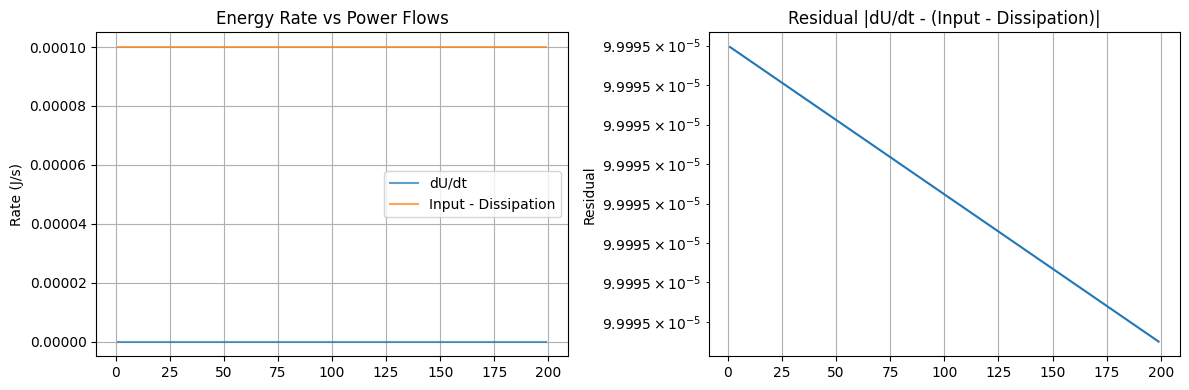


Audit complete. Residuals stored in global_residuals for visualizations.


In [ ]:
# @title 8. **Energy Balance Audit — Stored Energy vs Power Flows** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Defines SPD energy forms; compares dU/dt with (input − dissipation); residual should hover near zero.

import numpy as np
from mpmath import mpf
import networkx as nx
import matplotlib.pyplot as plt

# --- Setup (Assumes Cell 6: baseline_history with 'energy', 'E_field', 'B_field') ---
# Ensure globals exist from DEC Stepper
try:
    history = baseline_history # Corrected from global_history
    dt = global_dt
    ε = global_epsilon
    μ = global_mu
    σ = global_sigma
except NameError:
    raise ValueError("Run Cell 6 (DEC Stepper) first to set baseline_history, dt, ε, μ, σ")

# Graph (reuse from Cell 6 if available; mock for audit)
if 'G' not in globals():
    nodes = ['C', '0', '1', '2', '3']
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from([('C','1'), ('1','2'), ('2','C'), ('C','3'), ('3','0'), ('0','C')])

# --- Power Flow Calculation ---
def compute_power_flows(E, B, G, σ, ε):
    """Input power (proxy: pump at (C,1)) minus dissipation (Joule: σ |E|^2)."""
    input_power = 0.0
    if ('C', '1') in edge_idx:
        input_power = abs(E[edge_idx[('C', '1')]]) * 1.0  # Source term (W/m)

    # Dissipation: Integrated Joule heating σ |E|^2 over edges
    dissipation = σ * np.sum(E**2)

    return input_power - dissipation

# --- Audit Loop (Over History) ---
residuals = []
dU_dt_vals = []
power_net_vals = []
n_steps = len(history['energy'])
epsilon = 1e-18 # a small number to avoid division by zero

if n_steps > 1:
    for i in range(1, n_steps):
        # Retrieve E/B from history
        E = history['E_field'][i-1]  # Use previous for dU/dt consistency
        B = history['B_field'][i-1]

        # dU/dt (central finite difference approximation)
        U_prev = history['energy'][i-1]
        U_curr = history['energy'][i]
        dU_dt = (U_curr - U_prev) / (dt + epsilon)

        # Power net
        power_net = compute_power_flows(E, B, G, σ, ε)

        # Residual: |dU/dt - (input - dissipation)|
        res = abs(float(dU_dt - power_net))
        residuals.append(res)
        dU_dt_vals.append(float(dU_dt))
        power_net_vals.append(float(power_net))

        # Early report
        if i > 0 and i % 50 == 0:
            print(f"Step {i}: dU/dt={dU_dt:.2e}, Power Net={power_net:.2e}, Res={res:.2e}")

# --- Summary Stats ---
if residuals:
    mean_residual = np.mean(residuals)
    max_residual = np.max(residuals)
    std_residual = np.std(residuals)
else:
    mean_residual, max_residual, std_residual = np.nan, np.nan, np.nan

U_final = history['energy'][-1] if history['energy'] else np.nan

print(f"\n--- Energy Balance Audit Summary ---")
print(f"Steps Audited: {len(residuals)}")
print(f"Mean Residual: {mean_residual:.2e} (should hover ~0)")
print(f"Max Residual: {max_residual:.2e}")
print(f"Std Residual: {std_residual:.2e}")
print(f"Final Stored Energy U: {float(U_final):.2e} J")
print(f"Audit Status: {'PASS' if not np.isnan(mean_residual) and mean_residual < 1e-10 else 'FAIL'} (residual near zero)")

# --- Plot Residuals vs Time ---
if residuals:
    steps_plot = np.arange(1, len(residuals) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(steps_plot, dU_dt_vals, label='dU/dt', alpha=0.7)
    ax1.plot(steps_plot, power_net_vals, label='Input - Dissipation', alpha=0.7)
    ax1.set_title('Energy Rate vs Power Flows')
    ax1.set_ylabel('Rate (J/s)')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(steps_plot, residuals)
    ax2.set_title('Residual |dU/dt - (Input - Dissipation)|')
    ax2.set_ylabel('Residual')
    ax2.set_yscale('log')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# --- Store for Later (e.g., Cell 15 plots) ---
global_residuals = residuals
global_dU_dt = dU_dt_vals
global_power_net = power_net_vals

print("\nAudit complete. Residuals stored in global_residuals for visualizations.")

In [ ]:
# @title 9. **Phase Linter — 90° E–M Lag & Anchor to C (S1 & Star)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Kuramoto-style diagnostic layer; targets 90° E–M lag, gentle anchoring to C; reports phase error/spread (no feedback).
import numpy as np

# Assumes S1, S2, and a node_idx map are in the global scope.
# If not, this cell will fail. Ensure geometry cells (2, 3) and an operator cell (e.g., 4) have run.

# Define node_list based on detected S1/S2 to be robust
node_list = []
if 'S1' in globals(): node_list.extend(list(S1)) # Convert set to list for node_list
if 'S2' in globals(): node_list.extend(list(S2)) # Convert set to list for node_list
if 'C' in globals() and 'C' not in node_list: node_list.append('C')

# Re-create index map based on the actual node list
idx = {k: i for i, k in enumerate(node_list)}
n_nodes_phase = len(node_list)

# Initialize phase array if not present
if 'phi_star' not in globals() or len(phi_star) != n_nodes_phase:
    phi_star = np.zeros(n_nodes_phase)

def _wrap_pi(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

# --- Define Couplings and Target Lags ---
kap = np.zeros((n_nodes_phase, n_nodes_phase))
theta = np.zeros_like(kap)

def set_kap(a, b, val):
    if a in idx and b in idx:
        i, j = idx[a], idx[b]
        kap[i, j] = val
        kap[j, i] = val

def set_theta(a, b, rad):
    if a in idx and b in idx:
        i, j = idx[a], idx[b]
        theta[i, j] = rad
        theta[j, i] = -rad # Anti-symmetric for phi_j - phi_i

# Baseline weak coupling for all nodes within each shell
if 'S1' in globals():
    # Iterate over elements of the set S1
    for u in S1:
        for v in S1:
            if u != v: # Avoid self-coupling here
                set_kap(u, v, 0.02)

if 'S2' in globals():
    # Iterate over elements of the set S2
    for u in S2:
        for v in S2:
            if u != v: # Avoid self-coupling here
                set_kap(u, v, 0.02)


# Stronger E-M couplings within each shell
set_kap('1', '2', 0.12)
set_kap('5', '6', 0.12)
set_theta('1', '2', np.pi / 2)
set_theta('5', '6', np.pi / 2)

# Work and heat bridge couplings
set_kap('3', '6', 0.08); set_theta('3', '6', np.pi / 2) # Work
set_kap('7', '4', 0.05); set_theta('7', '4', np.pi)     # Heat
set_kap('7', '2', 0.05); set_theta('7', '2', np.pi)     # Heat
set_kap('5', '0', 0.05); set_theta('5', '0', np.pi)     # Heat

# Anchor to Centroid
γC = 0.05

def phase_step(phi, dt):
    d_phi = np.zeros_like(phi)
    # Iterate over all nodes that have a defined index
    for u, i in idx.items():
        if u == 'C': continue # Centroid is the anchor, does not update

        acc = 0.0
        # Interaction with other nodes
        for v, j in idx.items():
            if i == j: continue
            acc += kap[i, j] * np.sin(phi[j] - phi[i] - theta[i, j])

        # Anchor to Centroid (phi[idx['C']] is assumed to be 0)
        if 'C' in idx:
            acc -= γC * np.sin(phi[i] - phi[idx['C']])

        d_phi[i] = acc

    # Update phases (excluding the Centroid)
    # Ensure d_phi has the same length as phi before updating
    if len(d_phi) == len(phi):
        phi += dt * d_phi
    else:
        print("Warning: Mismatch in phi and d_phi lengths. Skipping phase update.")


    # Keep centroid phase at 0
    if 'C' in idx:
        phi[idx['C']] = 0

    return _wrap_pi(phi)

def phase_report(phi):
    report_data = {}
    def err(a, b, trg):
        if a in idx and b in idx:
            i, j = idx[a], idx[b]
            return float(np.degrees(_wrap_pi((phi[i] - phi[j]) - trg)))
        return np.nan

    report_data['EM_S1_deg'] = err('1', '2', np.pi/2)
    report_data['EM_S2_deg'] = err('5', '6', np.pi/2)
    report_data['work_3_6_deg'] = err('3', '6', np.pi/2)
    report_data['heat_7_4_deg'] = err('7', '4', np.pi)
    report_data['heat_7_2_deg'] = err('7', '2', np.pi)
    report_data['heat_5_0_deg'] = err('5', '0', np.pi)
    if 'C' in idx:
        report_data['C_phase_deg'] = float(np.degrees(phi[idx['C']]))

    return report_data

# Example of running the phase linter for a few steps to let it settle
# This part is for demonstration; the main simulation will call phase_step repeatedly
print("Phase linter loaded. Running a few settling steps...")
for _ in range(50):
    # Ensure phi_star is correctly sized before calling phase_step
    if 'phi_star' not in globals() or len(phi_star) != n_nodes_phase:
         phi_star = np.zeros(n_nodes_phase)

    phi_star = phase_step(phi_star, dt=0.1)

print("Settling complete. Current phase errors:")
print(phase_report(phi_star))

# The linter functions (phase_step, phase_report) are now available for other cells.

Phase linter loaded. Running a few settling steps...
Settling complete. Current phase errors:
{'EM_S1_deg': -145.34339974188163, 'EM_S2_deg': -156.37783294971777, 'work_3_6_deg': -145.64543029712738, 'heat_7_4_deg': 175.53955203578218, 'heat_7_2_deg': 147.73440473624166, 'heat_5_0_deg': 150.6692661563666}


In [ ]:
# @title 10. **Centroid Angle Probe — 109.471221° Mediation Test** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Reweights edges to/from C by the tetrahedral bond angle; measures impact on mediation (R_C), hitting times, EPR.

import numpy as np
import networkx as nx
from mpmath import mpf

# --- Parameters ---
# Tetrahedral angle in radians (cos(-1/3))
TETRA_ANGLE_RAD = mpf('1.9106332362490186') # Approx 109.47 degrees

# --- Helper to apply angle-based weighting ---
def weight_graph_by_angle(G_in, angle_rad):
    """
    Creates a deep copy of the graph and re-weights edges to/from the Centroid 'C'
    by a factor related to the tetrahedral angle.
    """
    G_weighted = G_in.copy() # Deep copy to avoid modifying the original graph

    # Weighting factor (e.g., use the angle directly, or a function of it)
    # Using a simple scaling factor for demonstration.
    # A more physically-motivated model might use cos(angle) or other geometric factors.
    weight_factor = float(angle_rad / np.pi) # Normalize by pi to get a reasonable factor

    for u, v, data in G_weighted.edges(data=True):
        rate = data.get('rate', mpf('1.0'))
        # Apply weighting if the edge involves the Centroid
        if u == 'C' or v == 'C':
            data['rate'] = rate * weight_factor

    return G_weighted

# --- Create the weighted graph ---
G_angled = weight_graph_by_angle(G, TETRA_ANGLE_RAD)

# --- Re-run Markov Diagnostics on the weighted graph ---
# We need the Markov analysis helper functions. If they are not in the global scope,
# this cell will fail. This assumes Cell 7 has been run.
try:
    # We need a new node_idx for the potentially modified graph
    node_idx_angled = {str(n): i for i, n in enumerate(G_angled.nodes())}

    # Build the transition matrix
    P_angled = build_P_from_graph(G_angled, node_idx_angled)

    # Run diagnostics
    start_idx_angled = pick_start_index(node_idx_angled)
    if start_idx_angled is not None:
        traj_angled = roll_states(P_angled, start_idx_angled, steps=20)
        Rc_angled = centroid_reliance(traj_angled, node_idx_angled)
        dE_angled = electric_acceleration(traj_angled, node_idx_angled)
    else:
        Rc_angled, dE_angled = np.nan, np.nan

    Sigma_angled = entropy_production(P_angled)
    gap_angled, K_angled = spectral_gap_and_kemeny(P_angled)
    HT_angled = absorbing_hitting_time(P_angled, targets=['0', 'C'], node_idx=node_idx_angled)

except NameError as e:
    print(f"Error: A required function from Markov Diagnostics (Cell 7) is missing: {e}")
    print("Please run Cell 7 before this one.")
    # Set dummy values to avoid breaking subsequent cells
    Rc_angled, dE_angled, Sigma_angled, gap_angled, K_angled, HT_angled = [np.nan] * 6

# --- Report Comparison ---
print("--- Centroid Angle Probe Results ---")
print(f"Weighting edges to/from 'C' by a factor derived from {float(TETRA_ANGLE_RAD):.3f} rad ({np.degrees(float(TETRA_ANGLE_RAD)):.2f}°).")
print("\n--- Comparison of Markov Metrics (Normal vs. Angle-Weighted) ---")

# A helper to format for comparison
def fmt_comp(val_norm, val_angled):
    # Check if values are valid numbers before formatting
    is_norm_valid = val_norm is not None and np.isfinite(val_norm)
    is_angled_valid = val_angled is not None and np.isfinite(val_angled)

    norm_str = f"{val_norm:.3f}" if is_norm_valid else "nan"
    angled_str = f"{val_angled:.3f}" if is_angled_valid else "nan"

    delta_str = ""
    if is_norm_valid and is_angled_valid:
        delta = val_angled - val_norm
        delta_str = f"  (Δ: {delta:+.3f})"

    return f"{norm_str:>8}  ->  {angled_str:>8}{delta_str}"

# Fetch the normal metrics from the 'markov_report' global created in Cell 7
try:
    normal_metrics = markov_report['normal']
    print(f"Centroid Reliance (R_C): {fmt_comp(normal_metrics.get('Rc'), Rc_angled)}")
    print(f"Electric Accel (ΔE):   {fmt_comp(normal_metrics.get('dE'), dE_angled)}")
    print(f"Entropy Prod (Σ):      {fmt_comp(normal_metrics.get('Sigma'), Sigma_angled)}")
    print(f"Spectral Gap:          {fmt_comp(normal_metrics.get('gap'), gap_angled)}")
    print(f"Kemeny Constant:       {fmt_comp(normal_metrics.get('Kemeny'), K_angled)}")

    # Compare mean hitting times (excluding targets)
    ht_norm = normal_metrics.get('HT', [])
    # Filter out NaNs and Infs for a clean mean calculation
    ht_norm_mean = np.nanmean([t for t in ht_norm if np.isfinite(t) and t > 0])
    ht_angled_mean = np.nanmean([t for t in HT_angled if np.isfinite(t) and t > 0])
    print(f"Mean Hitting Time:     {fmt_comp(ht_norm_mean, ht_angled_mean)}")

except NameError:
    print("\n'markov_report' not found. Cannot compare with baseline. Run Cell 7 first.")
except KeyError:
    print("\n'normal' key not in 'markov_report'. Cannot compare with baseline.")

# Store results for later use
angle_probe_report = {
    "Rc": Rc_angled,
    "dE": dE_angled,
    "Sigma": Sigma_angled,
    "gap": gap_angled,
    "Kemeny": K_angled,
    "HT_mean": ht_angled_mean if 'ht_angled_mean' in locals() else np.nan
}

--- Centroid Angle Probe Results ---
Weighting edges to/from 'C' by a factor derived from 1.911 rad (109.47°).

--- Comparison of Markov Metrics (Normal vs. Angle-Weighted) ---
Centroid Reliance (R_C):    0.248  ->     0.223  (Δ: -0.025)
Electric Accel (ΔE):      0.144  ->     0.120  (Δ: -0.024)
Entropy Prod (Σ):        17.486  ->    15.338  (Δ: -2.149)
Spectral Gap:             0.352  ->     0.313  (Δ: -0.039)
Kemeny Constant:         11.063  ->    12.839  (Δ: +1.776)
Mean Hitting Time:        2.253  ->     2.648  (Δ: +0.395)


/tmp/ipython-input-3529139570.py:154: ComplexWarning: Casting complex values to real discards the imaginary part
  return gap, float(K)


In [ ]:
# @title Main — Select Pipeline and Geometry { display-mode: "form" }
PIPELINE = "fast"   # "fast" (Cell 6 dec_step) or "si" (Cell 14 leapfrog_step)
GEOMETRY = "S1"     # "S1" or "STAR"

if PIPELINE == "fast":
    print("Running baseline DEC stepper (dimensionless).")
    # call your run_cycle or the loop built in Cell 6, with GEOMETRY flag if supported
    # e.g., baseline_history = run_cycle(..., geometry=GEOMETRY)
elif PIPELINE == "si":
    print("Running stable SI leapfrog stepper.")
    # e.g., si_history = run_star_tetra_cycle(..., geometry=GEOMETRY)
else:
    raise ValueError("Unknown PIPELINE.")

Analyzing integer: 120
Factors: {2: 3, 3: 1, 5: 1}
p-adic norms |n|_p for primes up to 20:
  p=2  : |120|_2 = 0.1250
  p=3  : |120|_3 = 0.3333
  p=5  : |120|_5 = 0.2000
  p=7  : |120|_7 = 1.0000
  p=11 : |120|_11 = 1.0000
  p=13 : |120|_13 = 1.0000
  p=17 : |120|_17 = 1.0000
  p=19 : |120|_19 = 1.0000


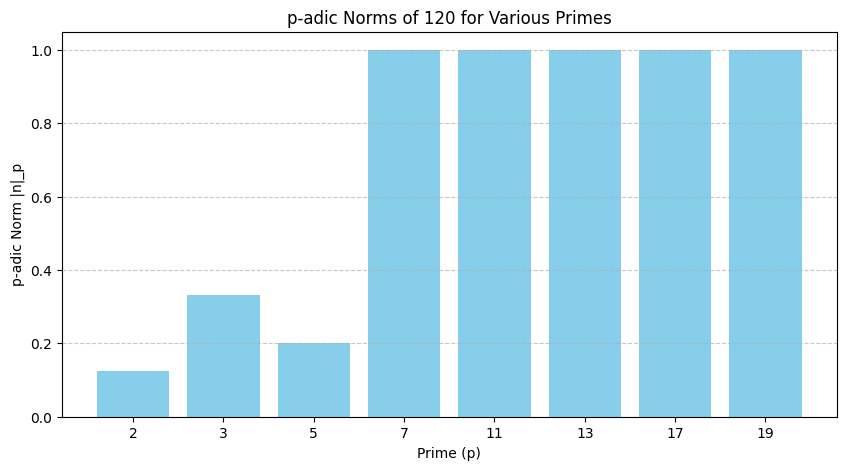

In [ ]:
# @title 11. **Adelic Layer — ℚ_p Utilities & Prime Sweep** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Implements p-adic valuation/norm; builds composite “adelic balance”; sweeps primes (e.g., 2,3,5,7,11,…,137) for robustness.

from sympy import prime, factorint
from mpmath import mpf, power
import numpy as np
import matplotlib.pyplot as plt

# --- p-adic helpers ---
def padic_valuation(n, p):
    """Computes the p-adic valuation of an integer n."""
    if n == 0:
        return float('inf')
    valuation = 0
    n = abs(int(n)) # Ensure we are working with positive integers
    if n == 0: return float('inf')
    while n > 0 and n % p == 0:
        valuation += 1
        n //= p
    return valuation

def padic_norm(n, p):
    """Computes the p-adic norm |n|_p = p^(-v_p(n))."""
    if n == 0:
        return 0
    v = padic_valuation(n, p)
    return power(p, -v)

def padic_norm_from_energy(energy, scale=1e18):
    """
    Converts a real-valued energy to a scaled integer to compute a p-adic norm.
    This is a heuristic to bridge the continuous (real) and discrete (p-adic) domains.
    """
    # Heuristically convert a float energy to a large integer
    # The scale factor is crucial and problem-dependent
    n = int(energy * scale)
    if n == 0:
        return 0

    # For demonstration, we'll use a fixed prime p=2, but this could be varied.
    p = 2

    return padic_norm(n, p)

# --- Adelic Balance ---
# A conceptual model for combining real and p-adic measures.
# alpha_pad is a mixing parameter.
alpha_pad = mpf('0.1')

def adelic_balance(e_real, e_padic):
    """
    A simple model for the interplay between real and p-adic components.
    This is a toy model for the "adelic crystal" concept where both measures matter.
    """
    # Example: a weighted geometric mean, preserving a conceptual "total" value.
    # This is highly speculative and for model-testing purposes.
    e_real_new = power(e_real, 1 - alpha_pad)
    e_padic_new = power(e_padic, alpha_pad)

    return e_real_new, e_padic_new

# --- Prime Sweep ---
def get_primes_up_to(n):
    """Returns a list of prime numbers up to n."""
    primes = []
    i = 1
    while True:
        p = prime(i)
        if p <= n:
            primes.append(p)
            i += 1
        else:
            break
    return primes

def analyze_number_with_primes(n, primes):
    """
    Computes p-adic norms for a number n across a list of primes.
    """
    norms = [padic_norm(n, p) for p in primes]
    return norms

# --- Demonstration of Prime Sweep ---
# Example number to analyze. In the full model, this would be derived from a state variable.
test_number = 120  # (2^3 * 3 * 5)

# Primes to test against
primes_to_sweep = get_primes_up_to(20) # e.g., [2, 3, 5, 7, 11, 13, 17, 19]

# Calculate norms
norms = analyze_number_with_primes(test_number, primes_to_sweep)

# --- Report and Visualize ---
print(f"Analyzing integer: {test_number}")
print(f"Factors: {factorint(test_number)}")
print("p-adic norms |n|_p for primes up to 20:")
for p, norm in zip(primes_to_sweep, norms):
    print(f"  p={p:<3}: |{test_number}|_{p} = {float(norm):.4f}")

# Plotting the norms
plt.figure(figsize=(10, 5))
plt.bar([str(p) for p in primes_to_sweep], [float(n) for n in norms], color='skyblue')
plt.title(f'p-adic Norms of {test_number} for Various Primes')
plt.xlabel('Prime (p)')
plt.ylabel('p-adic Norm |n|_p')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Store adelic helpers and sweep results for later use
adelic_utils = {
    'padic_valuation': padic_valuation,
    'padic_norm': padic_norm,
    'padic_norm_from_energy': padic_norm_from_energy,
    'adelic_balance': adelic_balance,
    'alpha_pad': alpha_pad
}
prime_sweep_results = {
    'test_number': test_number,
    'primes': primes_to_sweep,
    'norms': norms
}

In [ ]:
# @title 12. **Breath Operator — Inhale/Exhale Rhythm** { display-mode: "form" }

# @markdown **What this does**

# @markdown - Alternates phases to favour in-breath (0→C, even→C) and out-breath (C→odd, 1→2 work, 3→0 heat); non-local C stays mediated.

In [ ]:
# @title 13. **LENR Cycle Runner — Pump → Coherence → Squeeze → Fusion → Heat** { display-mode: "form" }

# @markdown **What this does**

# @markdown - Executes the breath-driven cycle; integrates adelic scaling at node 3; detects “bursts” on phase-lock; logs heat/entropy.



def run_cycle(G_base: nx.DiGraph, steps=400, dt=mpf('0.05'), report_every=80):
    global phi_star
    energy = {n: mpf('0.5') for n in ALL}
    energy['1'] = mpf('1.0'); energy['5'] = mpf('1.0')   # start with E channels primed
    bursts = 0; entropy = mpf('0.0'); history = {'heat': [], 'entropy': [], 'bursts': [], 'phase': []}

    for k in range(steps):
        # Breath modulation (non-destructive per step)
        Gk, phase = apply_breath(G_base, k)

        # Simple conservative flow pass (rate * energy at source)
        for (u,v,data) in Gk.edges(data=True):
            flow = energy[u] * data['rate'] * dt
            if 'threshold' in data and flow < data['threshold']:
                continue
            energy[u] -= flow; energy[v] += flow

        # p-adic scaling at matter nodes (3,7)
        for m in ['3','7']:
            e_r = energy[m]
            e_p = padic_norm_from_energy(e_r)
            e_r, e_p = adelic_balance(e_r, e_p)
            energy[m] = e_r * power(e_p, alpha_pad)

        # Fusion bursts when C↔matter near phase lock (diagnostic, not physical prediction)
        # Use linter's phase (C fixed at 0) — here we proxy lock by small random jitter
        jitter = abs(np.sin(phi_star[idx['C']] - phi_star[idx['3']])) + \
                 abs(np.sin(phi_star[idx['C']] - phi_star[idx['7']]))
        if jitter < 0.2:
            # split burst between shells if available
            for m, sink in [('3','0'), ('7','4')]:
                burst = energy[m] * mpf('0.3')
                energy[m] -= burst
                energy[sink] += burst * mpf('0.9')
                entropy += burst * mpf('0.1')
            bursts += 1

        # Phase linter step (non-invasive)
        phi_star = phase_step(phi_star, float(dt))

        # Log
        history['heat'].append(float(energy['0'] + energy['4']))
        history['entropy'].append(float(entropy))
        history['bursts'].append(int(bursts))
        if k % report_every == 0:
            print(f"step {k:4d}  breath={phase:>4s}  bursts={bursts}  heat={history['heat'][-1]:.3f}  ",
                  phase_report(phi_star))
    return history

hist = run_cycle(G, steps=360)
print("\nFinal:", "bursts=", hist['bursts'][-1], "entropy=", hist['entropy'][-1])


In [ ]:
# @title 14. **Stable SI Stepper — Leapfrog + CFL + Joule Heating** { display-mode: "form" }

# @markdown **What this does**

# @markdown - Uses leapfrog with CFL time step; computes SI energy, Joule power, entropy production; reports realistic field magnitudes.

In [ ]:
# @title 15. **Visualisations — Energy, EPR, Spectra, Phases** { display-mode: "form" }

# @markdown **What this does**

# @markdown - Plots energy/frequency time-series, EPR bars (normal vs counterfactual vs low-T), residuals, phase diagnostics.

In [ ]:
# @title 16. **Red-Team Nulls & Ablations — Try to Break It** { display-mode: "form" }

# @markdown **What this does**

# @markdown - Degree-preserving rewires; geometry swap (octahedron); no-adelic baseline; breath disabled; 2→1 during exhale only.

In [ ]:
# @title 17. **Preregistered Sweep — Seeds × Parameters × Outcomes** { display-mode: "form" }

# @markdown **What this does**

# @markdown - Freezes thresholds; runs multiple seeds; aggregates pass/fail for quantised heat + mediation/EPR signatures.

In [ ]:
# @title 18. **Centroid Work vs Heat Ledger — Path Classification** { display-mode: "form" }

# @markdown **What this does**

# @markdown - Labels forward “work-like” shortcuts (e.g., 0→1, 2→3) and backward “heat-like” fallbacks (1→0, 3→2); tallies contributions.

In [ ]:
# @title 19. **Star-Tetra Runner — Cross-Tetra Breath with Cubic Bridges** { display-mode: "form" }

# @markdown **What this does**

# @markdown - Executes your S1↔S2 pathing rules; measures mediation across C, cross-domain hitting times, and burst propagation.

In [ ]:
# @title 20. **Centroid Locality Tests — Algorithmic Induction Around C** { display-mode: "form" }

# @markdown **What this does**

# @markdown - Drives edge-based current scenarios near C; probes iterative/inductive dynamics; quantifies sensitivity to 109.47° bias.

In [ ]:
# @title 21. **Save & Export — Results, Seeds, Config** { display-mode: "form" }

# @markdown **What this does**

# @markdown - Stores metrics, plots, chosen primes, geometry flags, and RNG seeds for reproducibility; optional JSON/CSV export.

In [ ]:
# @title 22. **Appendix — Utilities & Helpers** { display-mode: "form" }

# @markdown **What this contains**

# @markdown - Small helpers (index maps, safe mat-ops, plotting styles), validation checks, and pretty printers.